![Partners](../images/partners.png)

# Wind Power Output

This notebook calculates wind power generation and analyzes ramping events using wind speed forecasts.

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from ecmwf.opendata import Client

import warnings
warnings.filterwarnings("ignore")

## 1. Power Plant Configuration

Find a list of power plants at https://openinframap.org/stats/area/Kenya/plants. 

* Kipeto Wind Power Station is a wind power plant operated by Kipeto Energy with a total output of 100 MW.

In [2]:
location_name = "Kipeto Wind Power Station"
lat_point = -1.74225
lon_point = 36.66670
output_mw = 100

## 2. Load Forecast Data

In [4]:
var_dict = {
    '100u': 'u100',   # 100m u-component of wind
    '100v': 'v100',   # 100m v-component of wind
}

area_bbox = [18, 32, -5, 52]  

# Parameters to download
parameters = ['100u', '100v']  

# Forecast steps (in hours, 6-hourly intervals up to 360 hours = 15 days)
steps = list(range(0, 60, 6))

# Output directory
oper_out_dir = Path("data/AIFS/output")
oper_out_dir.mkdir(parents=True, exist_ok=True)

client = Client(
    "ecmwf", 
    model="aifs-single",  # ECMWF's AI-based Integrated Forecast System
    resol="0p25",         # 0.25 degree resolution (~28 km)
)


for param in parameters:

    print(f"Downloading parameter: {param} ({var_dict.get(param, param)})")
    
    filename = 'tmp_oper.nc'
    
    # Retrieve operational forecast from latest run
    print("Retrieving data from ECMWF...")
    client.retrieve(
        date=0,           # Latest available date (0 = today)
        time=0,           # 00z run (can also use 6, 12, or 18 for other runs)
        step=steps,       # Forecast steps: 0, 6, 12, ..., 360 hours
        stream="oper",    # Operational high-resolution forecast
        type="fc",        # Forecast type
        levtype="sfc",    # Surface level
        param=param,      # Parameter to download
        target=filename   # Temporary file
    )
    print(f"Data downloaded to {filename}")

    print("Loading dataset...")
    ds = xr.open_dataset(filename, engine="cfgrib")

    # Convert step to timedelta and extract region
    ds['step'] = pd.to_timedelta(ds.step.values)
    ds = ds.sel(
        latitude=slice(area_bbox[0], area_bbox[2]), 
        longitude=slice(area_bbox[1], area_bbox[3])
    )

    # Get forecast initialization time
    forecast_datetime = ds.time.values
    forecast_datetime_str = pd.to_datetime(forecast_datetime).strftime("%Y%m%d%H%M%S")

    print(f"Forecast run time: {pd.to_datetime(forecast_datetime)}")
    print(f"Dataset shape: {ds[var_dict[param]].shape}")
    print(f"Time steps: {len(ds.step.values)}")

    # Save the extracted dataset
    out_fname = oper_out_dir / f'{forecast_datetime_str}-{steps[-1]}h_{param}.nc'
    ds.to_netcdf(out_fname)
    print(f"Saved to: {out_fname}")

    # Clean up temporary file
    Path(filename).unlink(missing_ok=True)

Retrieving data from ECMWF...


By downloading data from the ECMWF open data dataset, you agree to the terms: Attribution 4.0 International (CC BY 4.0). Please attribute ECMWF when downloading this data.
Data downloaded to tmp_oper.nc
Loading dataset...


Ignoring index file 'tmp_oper.nc.5b7b6.idx' older than GRIB file


Forecast run time: 2025-11-18 00:00:00
Dataset shape: (10, 93, 81)
Time steps: 10
Saved to: data/AIFS/output/20251118000000-54h_100u.nc
Retrieving data from ECMWF...


Ignoring index file 'tmp_oper.nc.5b7b6.idx' older than GRIB file


Data downloaded to tmp_oper.nc
Loading dataset...
Forecast run time: 2025-11-18 00:00:00
Dataset shape: (10, 93, 81)
Time steps: 10
Saved to: data/AIFS/output/20251118000000-54h_100v.nc


In [7]:
ds_100u = xr.open_dataset("data/AIFS/output/20251118000000-54h_100u.nc")
ds_100v = xr.open_dataset("data/AIFS/output/20251118000000-54h_100v.nc")

# compute magnitude
wind_speed = np.sqrt(ds_100u['u100']**2 + ds_100v['v100']**2)

# create dataset with variable "wind_speed" from dataarray
wind_speed_ds = wind_speed.to_dataset(name='wind_speed')

sh: 1: getfattr: not found
sh: 1: getfattr: not found


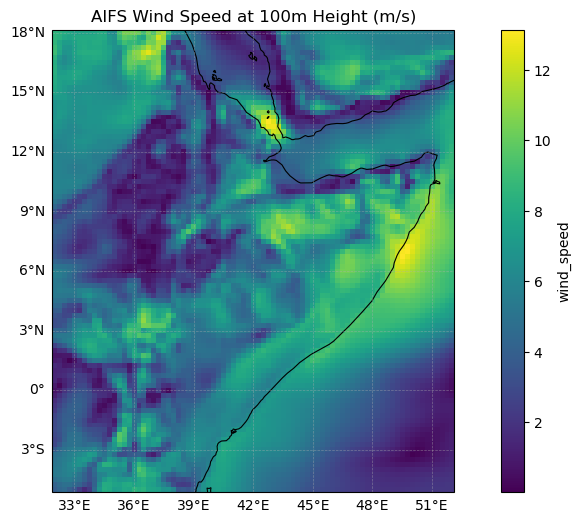

(<Figure size 1200x600 with 2 Axes>,
 <GeoAxes: title={'center': 'AIFS Wind Speed at 100m Height (m/s)'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>)

In [8]:
# plot wind speed at location

from plot import plot_variable
plot_variable(
    wind_speed_ds.sel(step="18:00:00"),
    var_name='wind_speed',
    title='AIFS Wind Speed at 100m Height (m/s)',
    )


In [9]:
forecast_location = wind_speed_ds['wind_speed'].sel(
    latitude=lat_point, 
    longitude=lon_point, 
    method='nearest'
)

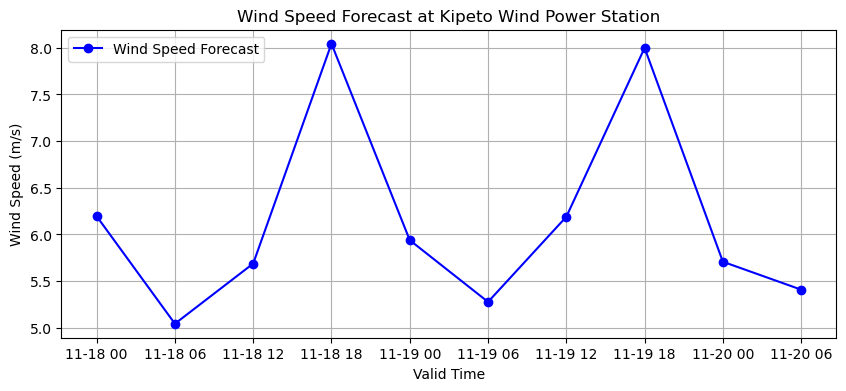

In [10]:
plt.figure(figsize=(10, 4))
plt.plot(forecast_location.valid_time, forecast_location, marker='o', label='Wind Speed Forecast', color='blue')
plt.title(f'Wind Speed Forecast at {location_name}')
plt.xlabel('Valid Time')
plt.ylabel('Wind Speed (m/s)')
plt.grid()
plt.legend()
plt.show()

In [11]:
# get daily mean values

# skip first value which is nan after diff
valid_times = forecast_location.valid_time[1:]

 # now get the daily sum from 6h intervals
forecast_sum_daily = forecast_location.groupby("valid_time.day").sum(dim="step")

# skip last day if incomplete
forecast_sum_daily = forecast_sum_daily[:-1]

valid_times_days = pd.date_range(
    start=pd.to_datetime(valid_times.values[0]).replace(hour=0, minute=0, second=0),
    end=pd.to_datetime(valid_times.values[-1]).replace(hour=0, minute=0, second=0),
    freq='D'
)[:-1]



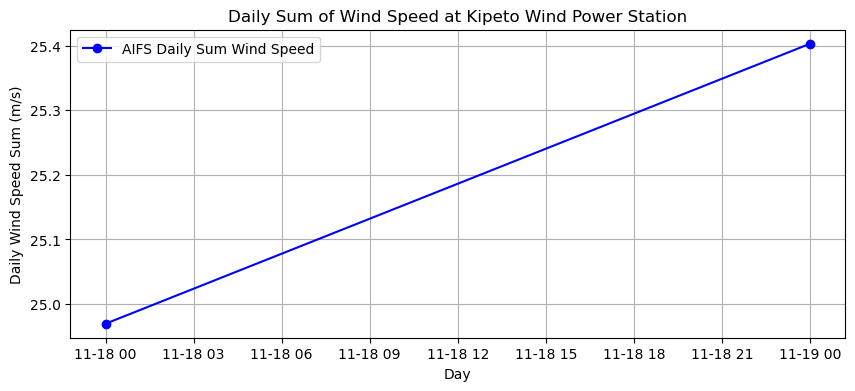

In [12]:
# plot daily sum of wind speed
plt.figure(figsize=(10, 4))
plt.plot(valid_times_days, forecast_sum_daily, marker='o', label='AIFS Daily Sum Wind Speed', color='blue')
plt.title(f'Daily Sum of Wind Speed at {location_name}')
plt.xlabel('Day')
plt.ylabel('Daily Wind Speed Sum (m/s)')
plt.grid()
plt.legend()
plt.show()

## 3. Wind Power Model

The power curve follows a cubic relationship below rated speed and caps at installed capacity.

In [13]:
def wind_power(
        v, 
        v_rated,
        C_wind=900.0
): 
    """
    Simple wind power model.
    Parameters:
    v : xarray.DataArray
        the forecasted wind speed at turbine hub height [m/s]
    v_rated : float
        the rated wind speed of the turbines [m/s]
    C_wind : float
        the total installed wind capacity [MW]
    """
    
    # Power curve (simplified)
    P_wind = xr.where(
        v < 0,
        0,
        xr.where(
            v < v_rated,
            C_wind * (v / v_rated) ** 3,
            C_wind
        )
    )

    return P_wind

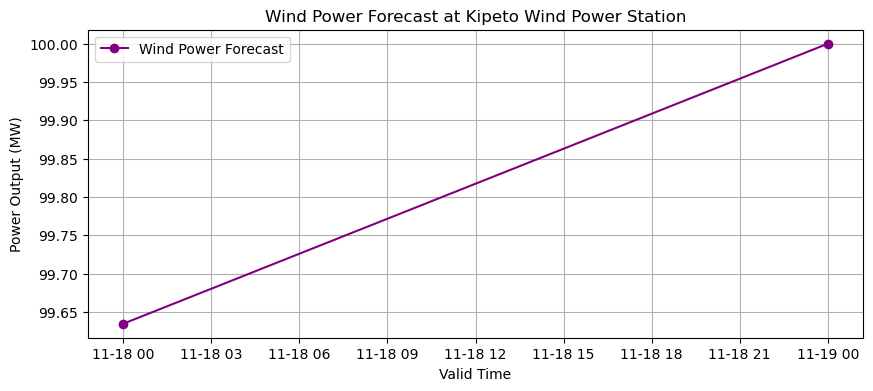

In [14]:
# Use daily sum of wind speed to calculate power forecast
power_forecast = wind_power(
    forecast_sum_daily, 
    v_rated=25.0, 
    C_wind=output_mw
)

plt.figure(figsize=(10, 4))
plt.plot(valid_times_days, power_forecast, marker='o', label='Wind Power Forecast',
            color='purple')
plt.title(f'Wind Power Forecast at {location_name}')
plt.xlabel('Valid Time')
plt.ylabel('Power Output (MW)')
plt.grid()
plt.legend()
plt.show()